# Маркетинговый анализ приложения Procrastinate Pro+

Цель: на основе данных о пользователях, привлечённых с 1 мая по 27 октября 2019 года (логи, выгрузка покупок и расходы на рекламу), определить, почему компания терпит убытки.

Задачи: 

- выяснить, откуда приходят пользователи и какими устройствами они пользуются
- сравнить стоимость привлечения из разных рекламных каналов
- рассчитать, сколько денег приносит каждый клиент и окупаются ли расходы на его привлечение
- определить, какие факторы мешают привлечению клиентов.

# Шаг 1. Загрузите данные и подготовьте их к анализу
Загрузите данные о визитах, заказах и расходах в переменные. Оптимизируйте данные для анализа. Убедитесь, что тип данных в каждой колонке — правильный. Путь к файлам:

 -   /datasets/visits_info_short.csv. 
 -   /datasets/orders_info_short.csv. 
 -   /datasets/costs_info_short.csv.

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

In [2]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')
events = None

In [3]:
visits.columns = visits.columns.str.lower()
orders.columns = orders.columns.str.lower()
costs.columns = costs.columns.str.lower()

visits.info()
visits['session start'] = pd.to_datetime(visits['session start'])
visits['session end'] = pd.to_datetime(visits['session end'])
print(visits.duplicated().sum()) 
visits.drop_duplicates()

orders.info()
orders['event dt'] = pd.to_datetime(orders['event dt'])
print(orders.duplicated().sum()) 
orders.drop_duplicates()

costs.info()
costs['dt'] = pd.to_datetime(costs['dt']).dt.date
print(costs.duplicated().sum()) 
costs.drop_duplicates()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session start  309901 non-null  object
 5   session end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user id   40212 non-null  int64  
 1   event dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Colum

dt         channel  costs
0     2019-05-01        FaceBoom  113.3
1     2019-05-02        FaceBoom   78.1
2     2019-05-03        FaceBoom   85.8
3     2019-05-04        FaceBoom  136.4
4     2019-05-05        FaceBoom  122.1
...          ...             ...    ...
1795  2019-10-23  lambdaMediaAds    4.0
1796  2019-10-24  lambdaMediaAds    6.4
1797  2019-10-25  lambdaMediaAds    8.8
1798  2019-10-26  lambdaMediaAds    8.8
1799  2019-10-27  lambdaMediaAds   12.0

[1800 rows x 3 columns]

# Шаг 2. Задайте функции для расчета и анализа LTV, ROI, удержания и конверсии

In [4]:
#функция для расчёта удержания

def get_retention(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],  # новый параметр dimensions
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        visits[['user id', 'session start']], on='user id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session start'] - result_raw['first ts']
    ).dt.days

    # рассчитываем удержание
    # новый вариант с dimensions
    result_grouped = result_raw.pivot_table(
        index=dimensions, 
        columns='lifetime',
        values='user id',
        aggfunc='nunique',
    )
    cohort_sizes = (
        result_raw.groupby(dimensions)  
        .agg({'user id': 'nunique'})
        .rename(columns={'user id': 'cohort_size'})
    )
    result_grouped = cohort_sizes.merge(
        result_grouped, on=dimensions, how='left'  
    ).fillna(0)
    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)

    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_days))
    ]

    # восстанавливаем столбец с размерами когорт
    result_grouped['cohort_size'] = cohort_sizes

    # возвращаем таблицу удержания и сырые данные
    return result_raw, result_grouped

#функция для расчёта конверсии

def get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_orders = (
        orders.sort_values(by=['user id', 'event dt'])
        .groupby('user id')
        .agg({'event dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_orders[['user id', 'event dt']], on='user id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event dt'] - result_raw['first ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу конверсии
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user id', aggfunc='nunique'
        )
        # считаем сумму с накоплением для каждой строки
        result = result.fillna(0).cumsum(axis = 1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user id': 'nunique'})
            .rename(columns={'user id': 'cohort_size'})
        )
        # добавляем размеры когорт в таблицу конверсии
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [5]:
def get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(
        orders[['user id', 'event dt', 'revenue']], on='user id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['event dt'] - result_raw['first ts']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user id': 'nunique'})
            .rename(columns={'user id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        cac = df[['user id', 'acquisition_cost'] + dims].drop_duplicates()
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )
        roi = result.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )
    if 'cohort' in dimensions:
        dimensions = []
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )




# Шаг 3. Проведите исследовательский анализ данных

Постройте профили пользователей. Определите минимальную и максимальную дату привлечения пользователей.

Выясните:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

In [6]:
def get_profiles(visits, orders):

    # сортируем сессии по ID пользователя и дате первого посещения
    # группируем по ID и находим первые значения session_start и channel
    # столбец с временем первого посещения назовём first_ts
    
    profiles = (
        visits.sort_values(by=['user id', 'session start'])
        .groupby('user id')
        .agg({'session start': 'first', 
              'channel': 'first',
              'region': 'first',
               'device': 'first'})
        .rename(columns={'session start': 'first ts'})
        .reset_index()  # возвращаем user_id из индекса
    )

    # определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    
    profiles['dt'] = profiles['first ts'].dt.date
    profiles['month'] = profiles['first ts'].astype('datetime64[M]')
    
     # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user id'].isin(orders['user id'].unique())
    
    return profiles 


profiles = get_profiles(visits, orders)

In [7]:
#определим минимальную и максимальную даты привлечения

print(profiles['dt'].min())
print(profiles['dt'].max())

2019-05-01
2019-10-27


In [8]:
#умножим среднюю долю платящих на общее количество пользователей по регионам (устройствам, каналам)

payers_region = profiles.groupby('region').agg({'payer':'mean'}).sort_values(by='payer', ascending=False).reset_index()

users_region = visits.groupby('region').agg({'user id':'nunique'}).reset_index()
payers_number = pd.merge(payers_region, users_region, on='region')
payers_number['number'] = payers_number['payer']*payers_number['user id']
print('Из каких стран приходят пользователи:') 
print(payers_number.sort_values(by='number', ascending=False))

Из каких стран приходят пользователи:
          region     payer  user id  number
0  United States  0.069019   100002  6902.0
2             UK  0.039829    17575   700.0
3         France  0.037994    17450   663.0
1        Germany  0.041119    14981   616.0


In [9]:
payers_device = profiles.groupby('device').agg({'payer':'mean'}).sort_values(by='payer', ascending=False).reset_index()

users_device = visits.groupby('device').agg({'user id':'nunique'}).reset_index()
payers_number_dev = pd.merge(payers_device, users_device, on='device')
payers_number_dev['number'] = payers_number_dev['payer']*payers_number_dev['user id']
print('')
print('С каких устройств чаще заходят пользователи:')
print(payers_number_dev.sort_values(by='number', ascending=False))


С каких устройств чаще заходят пользователи:
    device     payer  user id       number
1   iPhone  0.062079    55798  3463.882156
2  Android  0.058518    36377  2128.706611
0      Mac  0.063644    31335  1994.291991
3       PC  0.050468    31681  1598.873650


In [10]:
payers_channel = profiles.groupby('channel').agg({'payer':'mean'}).sort_values(by='payer', ascending=False)

users_channel = visits.groupby('channel').agg({'user id':'nunique'}).reset_index()
payers_number_ch = pd.merge(payers_channel, users_channel, on='channel')
payers_number_ch['number'] = payers_number_ch['payer']*payers_number_ch['user id']
print('')
print('По каким рекламным каналам идёт привлечение:')
print(payers_number_ch.sort_values(by='number', ascending=False))


По каким рекламным каналам идёт привлечение:
               channel     payer  user id       number
0             FaceBoom  0.122049    29916  3651.221932
3               TipTop  0.096007    20204  1939.732734
10             organic  0.020553    57673  1185.362604
1           AdNonSense  0.113402     4199   476.175258
5       WahooNetBanner  0.052964     8845   468.465451
4       RocketSuperAds  0.079137     4988   394.733813
8              LeapBob  0.030633     8875   271.863674
2       lambdaMediaAds  0.104700     2410   252.326664
9   OppleCreativeMedia  0.027077     8929   241.773039
6              YRabbit  0.038265     4882   186.811224
7         MediaTornado  0.035747     4895   174.981668


Вывод: имеются данные о пользователях из США, Германии, Франции и Великобритании, больше всеего платящих пользователей приходит из США; платящие пользователи чаще всего заходят с iPhone; самые популярные каналы, из которых приходят платящие пользователи - FaceBoom, TipTop и огранический трафик.

# Шаг 4. Маркетинг

Выясните:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

105497.30000000002


channel     costs     share
0          AdNonSense   3911.25  0.037074
1            FaceBoom  32445.60  0.307549
2             LeapBob   1797.60  0.017039
3        MediaTornado    954.48  0.009047
4  OppleCreativeMedia   2151.25  0.020392
5      RocketSuperAds   1833.00  0.017375
6              TipTop  54751.30  0.518983
7      WahooNetBanner   5151.00  0.048826
8             YRabbit    944.22  0.008950
9      lambdaMediaAds   1557.60  0.014764

costs
month                
2019-05-01   9978.570
2019-06-01  15090.045
2019-07-01  16447.060
2019-08-01  20657.870
2019-09-01  22441.340
2019-10-01  20882.415

<AxesSubplot:xlabel='month'>

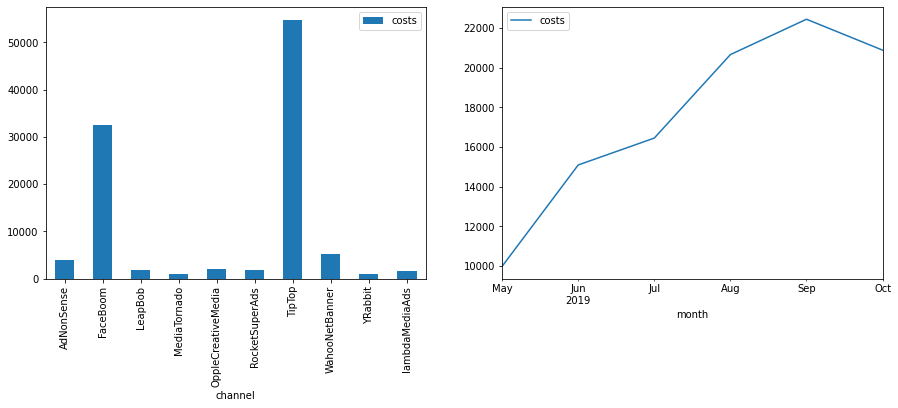

In [11]:
#всего потрачено
print(costs['costs'].sum())
#на каждый источник
channel_costs = costs.groupby('channel').agg({'costs':'sum'}).reset_index()
channel_costs['share'] = channel_costs['costs']/channel_costs['costs'].sum()
display(channel_costs)

#по времени
costs['month'] = costs['dt'].astype('datetime64[M]')
display(costs.groupby('month').agg({'costs':'sum'}))

plt.figure(figsize=(15, 5))
(costs.groupby('channel').agg({'costs':'sum'})).plot(kind='bar', ax=plt.subplot(1, 2, 1))
(costs.groupby('month').agg({'costs':'sum'})).plot(ax=plt.subplot(1, 2, 2))  

In [12]:
#средняя стоимость привлечения одного покупателя вообще и для каждого источника трафика


# добавляем параметр ad_costs — траты на рекламу
def get_profiles(visits, orders, events, costs, event_names=[]):

    # сортируем сессии по ID пользователя и дате привлечения
    # группируем по ID и находим параметры первых посещений
    profiles = (
        visits.sort_values(by=['user id', 'session start'])
        .groupby('user id')
        .agg(
            {
                'session start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
         # время первого посещения назовём first_ts
        .rename(columns={'session start': 'first ts'})
        .reset_index()  # возвращаем user_id из индекса
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first ts'].dt.date
    profiles['month'] = profiles['first ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user id'].isin(orders['user id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            # проверяем, встречается ли каждый пользователь
            # среди тех, кто совершил событие event
            profiles[event] = profiles['user id'].isin(
                events.query('event_name == @event')['user id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковым источником 
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user id': 'nunique'})
         # столбец с числом пользователей назовём unique_users
        .rename(columns={'user id': 'unique_users'})
        .reset_index()  # возвращаем channel из индексов
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    # по дате и каналу привлечения
    costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    costs['acquisition_cost'] = costs['costs'] / costs['unique_users']

    # добавим стоимость привлечения в профили
    profiles = profiles.merge(
        costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # органические пользователи не связаны с данными о рекламе,
    # поэтому в столбце acquisition_cost у них значения NaN
    # заменим их на ноль, ведь стоимость привлечения равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles  # возвращаем профили с CAC

profiles = get_profiles(visits, orders, events, costs, event_names=[])
profiles = profiles.query('channel != "organic"')

print('Стоимость привлечения каждого пользователя')
profiles[['user id', 'acquisition_cost']].head()

Стоимость привлечения каждого пользователя


user id  acquisition_cost
0    599326          1.088172
1   4919697          1.107237
3  22593348          0.988235
4  31989216          0.230769
7  46006712          1.008000

In [13]:
print('Cредний CAC на одного пользователя для всего проекта')
print(profiles['acquisition_cost'].mean())

Cредний CAC на одного пользователя для всего проекта
1.1274813239427588


In [14]:
print('Cредний CAC на одного пользователя для каждого источника')
print(profiles.groupby('channel').agg({'acquisition_cost':'mean'}))

Cредний CAC на одного пользователя для каждого источника
                    acquisition_cost
channel                             
AdNonSense                  1.008054
FaceBoom                    1.113286
LeapBob                     0.210172
MediaTornado                0.218717
OppleCreativeMedia          0.250000
RocketSuperAds              0.412095
TipTop                      2.799003
WahooNetBanner              0.602245
YRabbit                     0.218975
lambdaMediaAds              0.724802


Для платформы TipTop CAC значительно выше среднего, и в целом расходы на рекламу по этому каналу очень высокие.

# Шаг 5. Оцените окупаемость рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируйте общую окупаемость рекламы;
- Проанализируйте окупаемость рекламы с разбивкой по устройствам;
- Проанализируйте окупаемость рекламы с разбивкой по странам;
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам.

Опишите проблемы, которые вы обнаружили. Ответьте на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Опишите возможные причины обнаруженных проблем и сформируйте рекомендации для рекламного отдела. При решении этого шага считайте, что вы смотрите данные 1-го ноября 2019 года и что в вашей организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

### Проанализируйте общую окупаемость рекламы

In [15]:
users = get_profiles(visits, orders, events, costs, event_names=[])  # профили с CAC
users = users.query('channel != "organic"')

# получите сырые данные, таблицы LTV и ROI, а также таблицы динамики LTV и ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    users,
    orders,
    datetime(2019, 11, 1).date(),
    14,
    dimensions=[]
)

display(ltv, roi)


cohort_size      0.0       1.0       2.0      3.0       4.0  \
cohort                                                                   
All users        88644  0.34558  0.435754  0.504507  0.56109  0.611436   

                5.0      6.0       7.0       8.0       9.0      10.0     11.0  \
cohort                                                                          
All users  0.654368  0.69414  0.729778  0.764619  0.796665  0.826152  0.85207   

               12.0     13.0  
cohort                        
All users  0.878116  0.90203

cohort_size       cac       0.0       1.0       2.0       3.0  \
cohort                                                                     
All users        88644  1.117794  0.309163  0.389834  0.451341  0.501962   

                4.0      5.0       6.0       7.0       8.0       9.0  \
cohort                                                                 
All users  0.547002  0.58541  0.620991  0.652873  0.684043  0.712711   

               10.0      11.0      12.0      13.0  
cohort                                             
All users  0.739091  0.762278  0.785579  0.806974

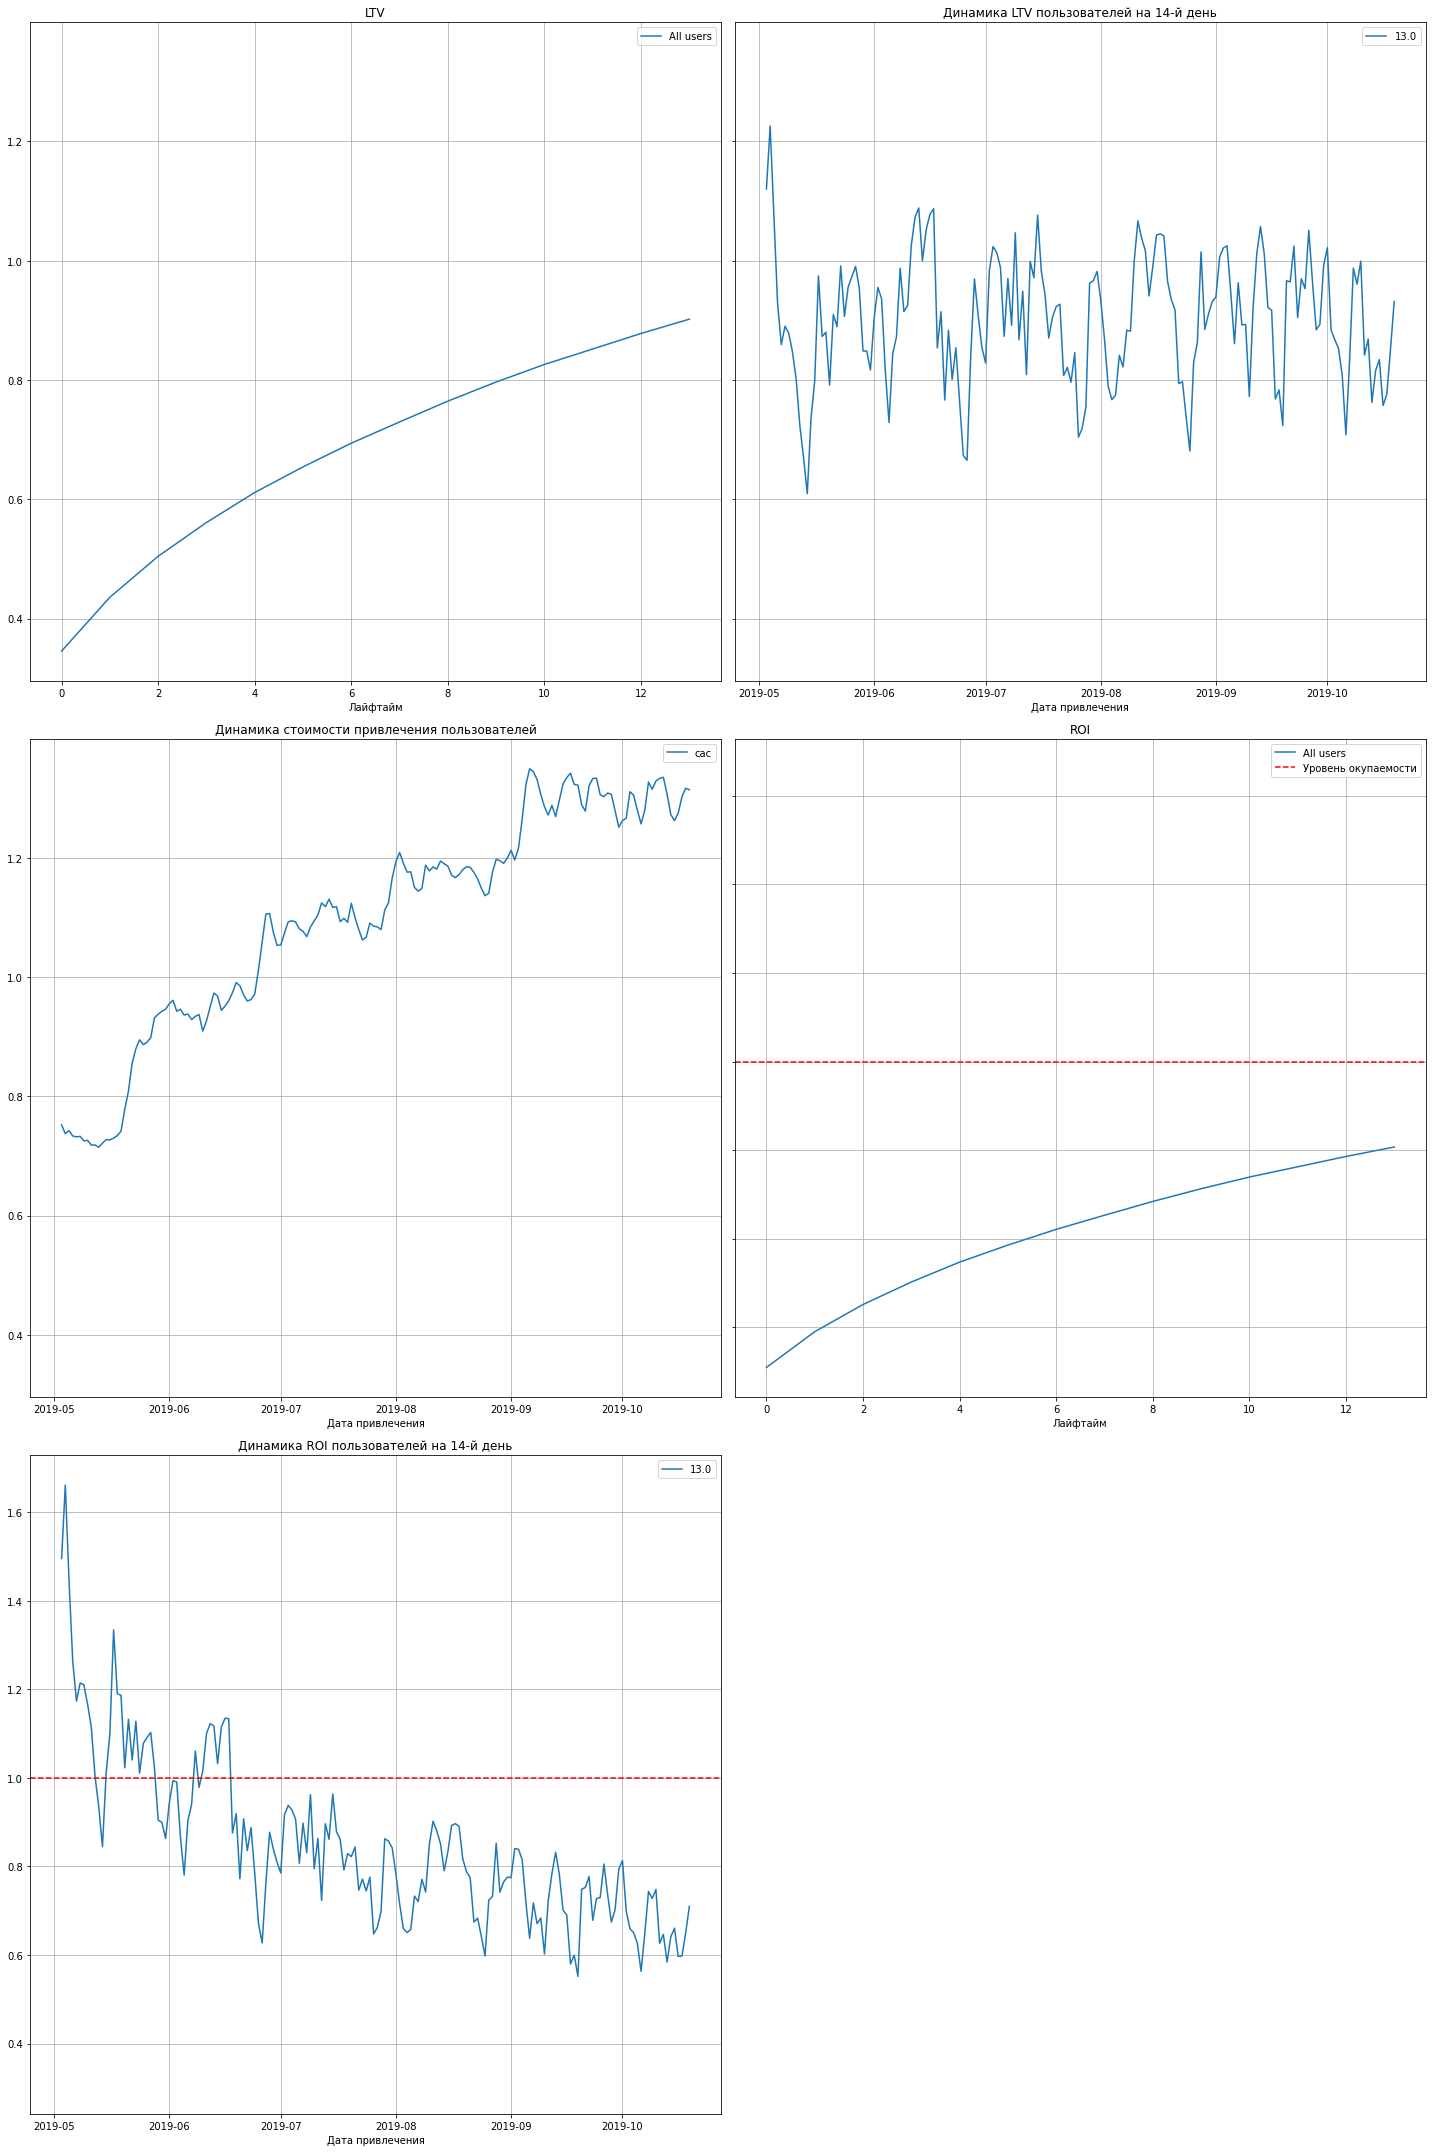

In [16]:
# добавим функциb для сглаживания данных и для визуализации LTV и ROI

def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(20, 30))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
    cac_history = roi_history[['cac']]
    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(3, 2, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(3, 2, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(3, 2, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(3, 2, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(3, 2, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()


# разбиваем траты на рекламу по дням

min_date = datetime(2019, 5, 1)
max_date = datetime(2020, 10, 27)
days_num = (max_date - min_date).days
daily_costs = []
for index, values in costs.iterrows():
    channel_name = values['channel']
    channel_costs = values['costs']
    avg_channel_costs = channel_costs / days_num
    for i in range(days_num):
        current_day = min_date + timedelta(days=i)
        daily_costs += [[current_day, channel_name, avg_channel_costs]]
daily_costs = pd.DataFrame(daily_costs, columns=['dt', 'channel', 'costs'])
daily_costs['dt'] = daily_costs['dt'].dt.date

users = get_profiles(visits, orders, events, costs, event_names=[])
users = users.query('channel != "organic"')
# профили с CAC

# получите сырые данные, таблицы LTV и ROI, а также таблицы динамики LTV и ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    users,
    orders,
    datetime(2019, 11, 1).date(),
    14,
    dimensions=[]
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=3) # постройте графики LTV, CAC и ROI

По графику видно, что реклама не окупается: с LTV проблем нет, но стоимость привлечения пользователей увеличивается

### Проанализируйте окупаемость рекламы с разбивкой по устройствам

cohort_size       cac       0.0       1.0       2.0       3.0  \
device                                                                   
Android        20683  1.019759  0.332645  0.422419  0.490517  0.544460   
Mac            17747  1.276219  0.299506  0.376283  0.431058  0.474117   
PC             18128  0.792724  0.349933  0.456068  0.542966  0.612637   
iPhone         32086  1.277021  0.288114  0.357321  0.410253  0.456661   

              4.0       5.0       6.0       7.0       8.0       9.0      10.0  \
device                                                                          
Android  0.596376  0.648580  0.686250  0.724251  0.758989  0.791216  0.817714   
Mac      0.510255  0.537354  0.565601  0.589926  0.619766  0.646735  0.671809   
PC       0.680712  0.733701  0.796291  0.835044  0.884297  0.920135  0.960624   
iPhone   0.495005  0.527449  0.556536  0.587035  0.610762  0.636023  0.658115   

             11.0      12.0      13.0  
device                                 
Android  0.839481  0.870765  0.894425  
Mac      0.692961  0.708825  0.729139  
PC       0.994933  1.024449  1.054801  
iPhone   0.679258  0.700380  0.718064

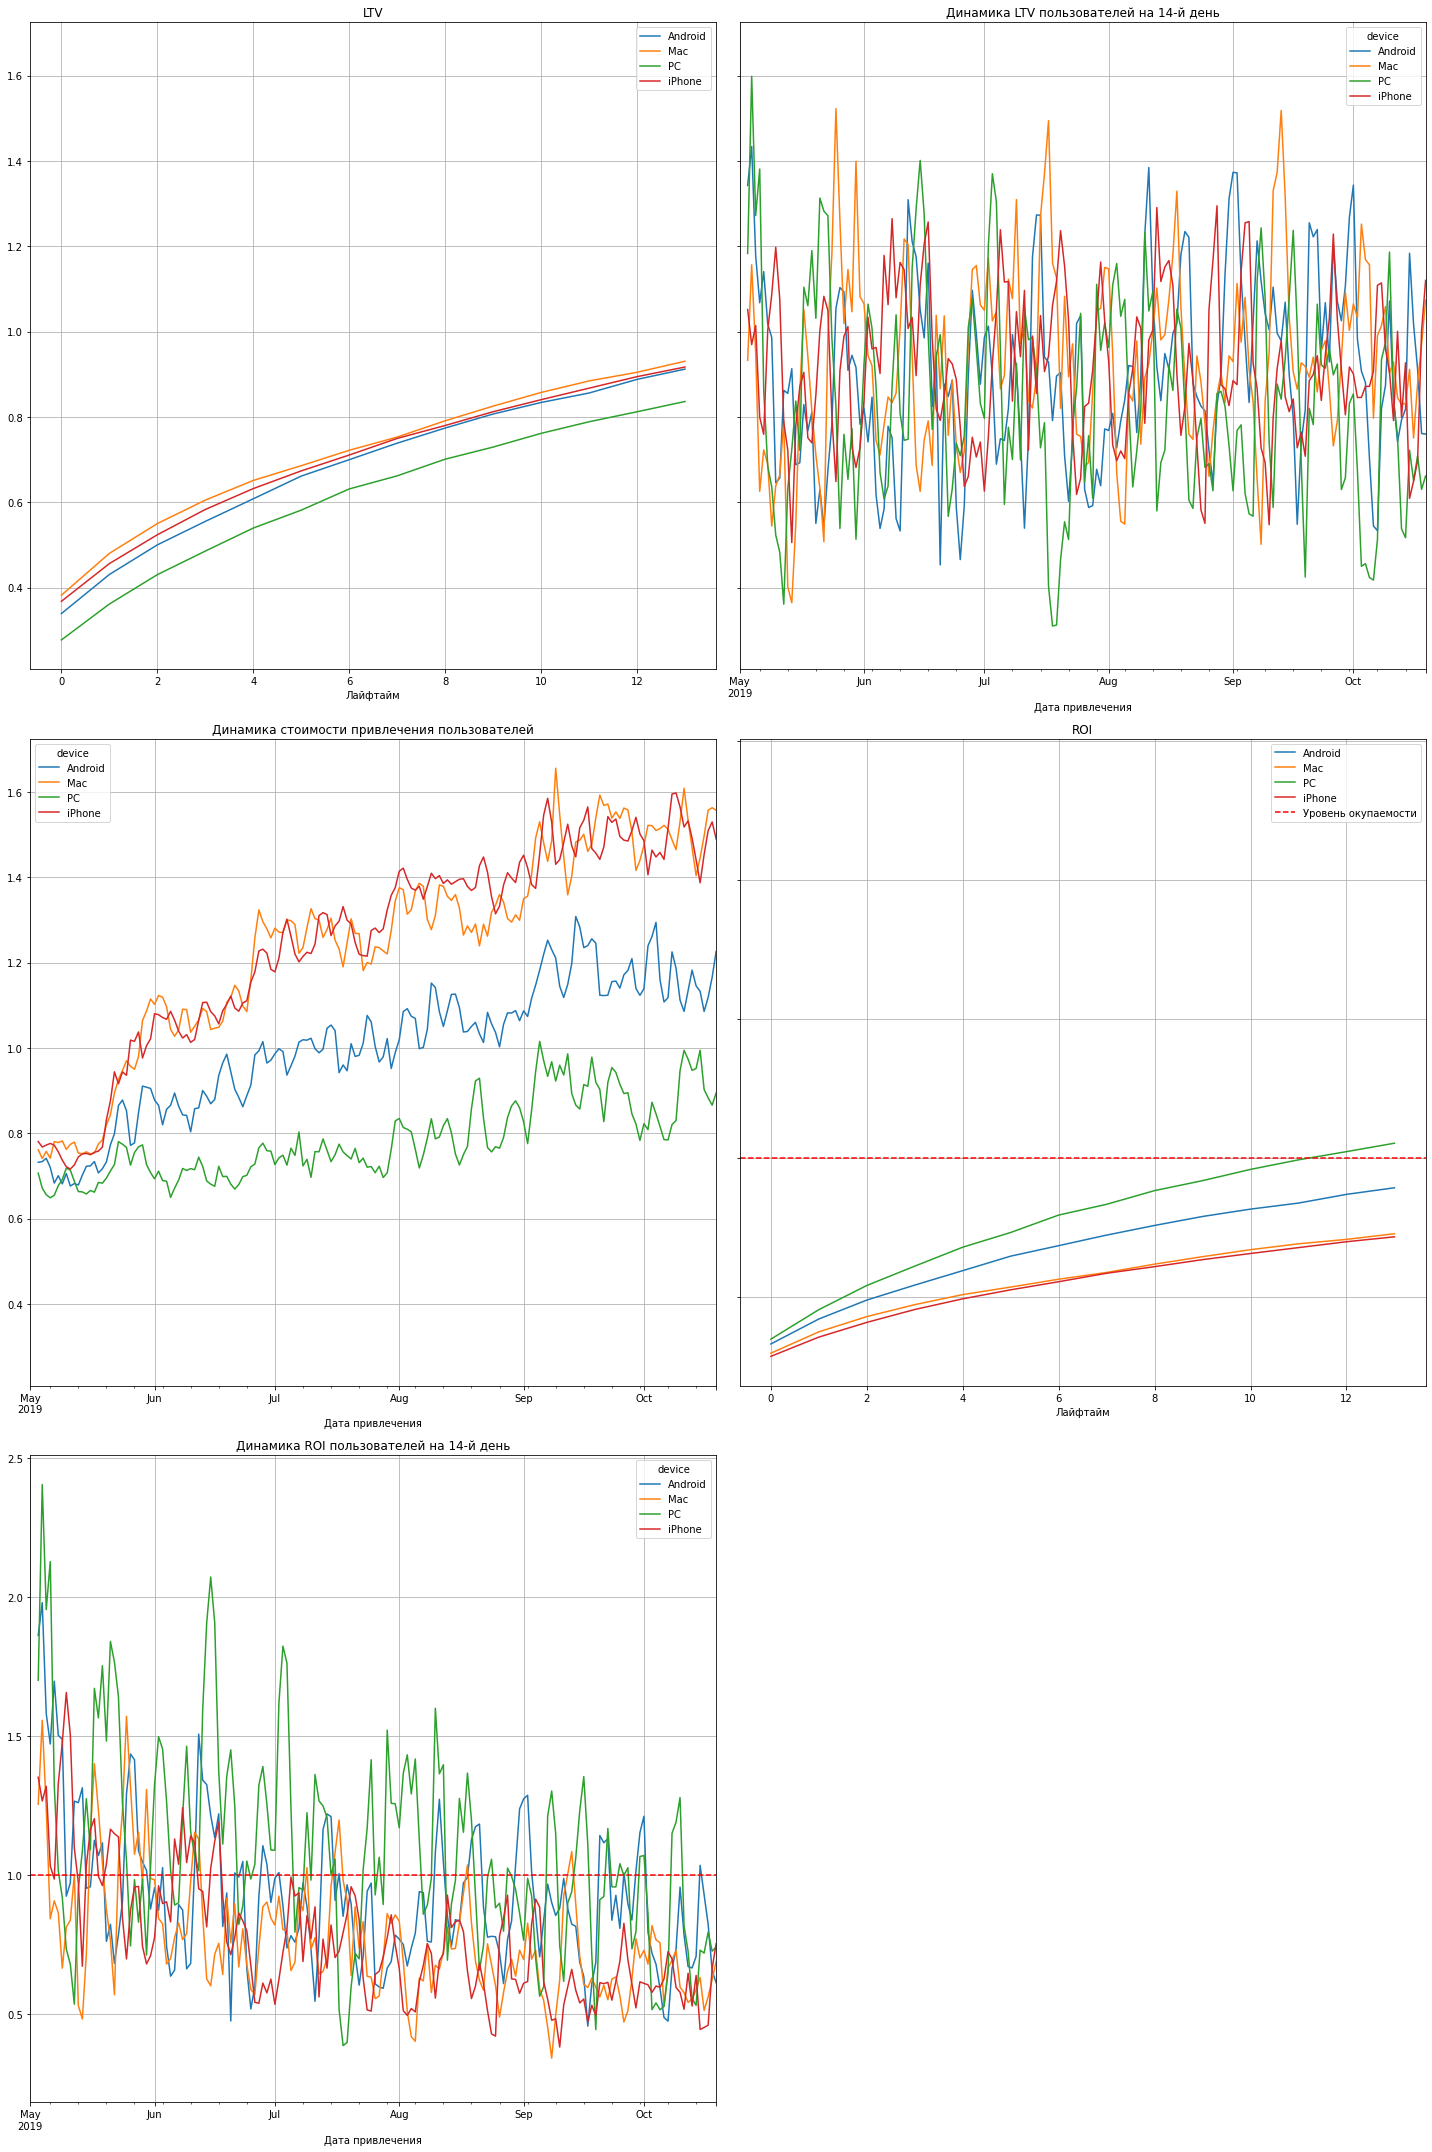

In [17]:
users = get_profiles(visits, orders, events, costs, event_names=[])  # профили с CAC
users = users.query('channel != "organic"')

# получите сырые данные, таблицы LTV и ROI, а также таблицы динамики LTV и ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    users,
    orders,
    datetime(2019, 11, 1).date(),
    14,
    dimensions=['device']
)

display(roi)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=3)

Реклама окупается только на PC, и для всех устройств растёт стоимость привлечения.

### Проанализируйте окупаемость рекламы с разбивкой по странам

cohort_size       cac       0.0       1.0       2.0       3.0  \
region                                                                         
France               10516  0.459836  0.420645  0.564947  0.677842  0.783319   
Germany               9030  0.464898  0.400840  0.556806  0.705411  0.807645   
UK                   10536  0.454922  0.480704  0.652335  0.808109  0.915777   
United States        58562  1.455876  0.288682  0.356923  0.405928  0.447689   

                    4.0       5.0       6.0       7.0       8.0       9.0  \
region                                                                      
France         0.884863  0.978985  1.046066  1.103029  1.177559  1.241542   
Germany        0.909395  0.991414  1.068917  1.148797  1.228449  1.302148   
UK             1.023264  1.107802  1.222385  1.287350  1.371094  1.418984   
United States  0.483222  0.513729  0.541018  0.567254  0.590622  0.613990   

                   10.0      11.0      12.0      13.0  
region                                                 
France         1.304903  1.352373  1.413265  1.457644  
Germany        1.379887  1.432426  1.487111  1.533709  
UK             1.470208  1.521847  1.582249  1.634306  
United States  0.634347  0.653111  0.670649  0.687776

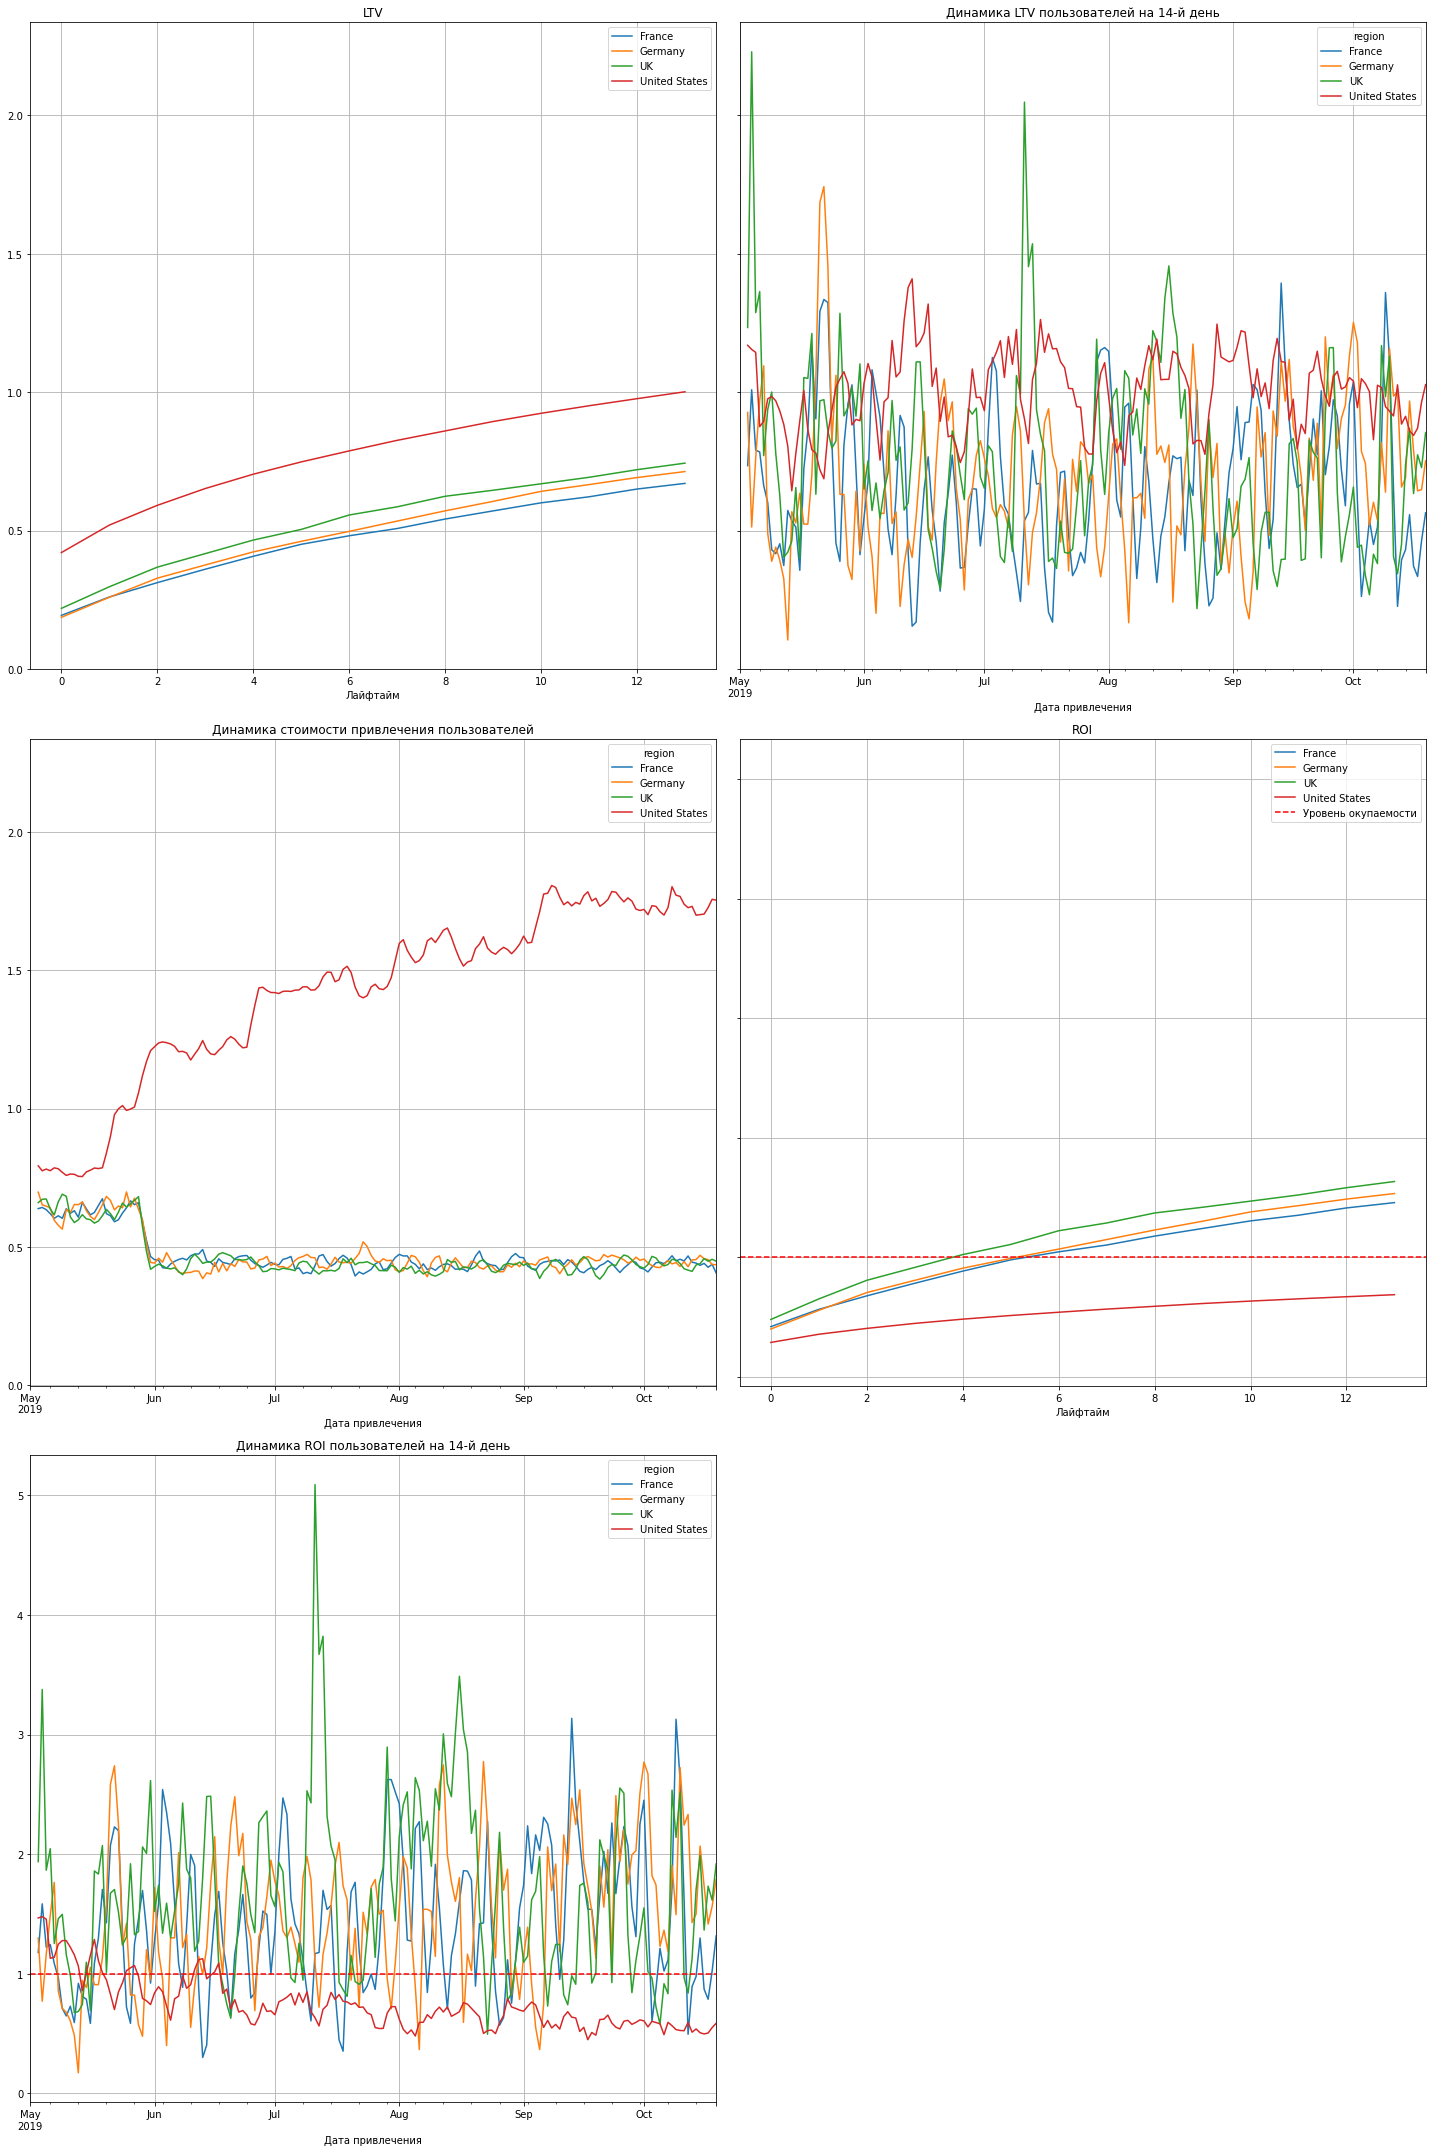

In [18]:
users = get_profiles(visits, orders, events, costs, event_names=[])  # профили с CAC
users = users.query('channel != "organic"')

# получите сырые данные, таблицы LTV и ROI, а также таблицы динамики LTV и ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    users,
    orders,
    datetime(2019, 11, 1).date(),
    14,
    dimensions=['region']
)

display(roi)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=3)

В США окупаемость рекламы значительно ниже, чем в Англии, Германии и Франции. При этом каждый клиент из США приносит даже больше денег, чем клиенты из других регионов, но стоимость привлечения новых клиентов очень высокая.

### Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам

cohort_size       cac       0.0       1.0       2.0  \
channel                                                                   
AdNonSense                 3702  1.008023  0.501010  0.584460  0.639288   
FaceBoom                  27544  1.113419  0.526040  0.593510  0.629343   
LeapBob                    8103  0.210000  0.509752  0.741436  0.978967   
MediaTornado               4167  0.219035  0.627684  0.874814  1.127410   
OppleCreativeMedia         8139  0.249908  0.389100  0.526504  0.686996   
RocketSuperAds             4251  0.417431  0.497256  0.763336  0.948932   
TipTop                    18498  2.757774  0.124575  0.180359  0.226321   
WahooNetBanner             8082  0.601856  0.317853  0.484298  0.629588   
YRabbit                    4102  0.217087  0.752238  0.983122  1.179250   
lambdaMediaAds             2056  0.727237  0.632899  0.887333  1.070887   

                         3.0       4.0       5.0       6.0       7.0  \
channel                                                                
AdNonSense          0.678069  0.701069  0.726752  0.748147  0.761519   
FaceBoom            0.654599  0.671035  0.682914  0.695801  0.704818   
LeapBob             1.120908  1.236450  1.374282  1.498034  1.589535   
MediaTornado        1.340729  1.516873  1.675432  1.773841  1.910531   
OppleCreativeMedia  0.826849  0.964769  1.065354  1.161037  1.238564   
RocketSuperAds      1.092347  1.235204  1.367935  1.531090  1.646391   
TipTop              0.268272  0.305449  0.339298  0.367570  0.397585   
WahooNetBanner      0.737309  0.858780  0.946188  1.049868  1.126808   
YRabbit             1.400049  1.641119  1.786814  1.910094  2.022179   
lambdaMediaAds      1.245178  1.432136  1.595673  1.735841  1.859323   

                         8.0       9.0      10.0      11.0      12.0      13.0  
channel                                                                         
AdNonSense          0.782922  0.796294  0.800573  0.808597  0.820631  0.831337  
FaceBoom            0.711685  0.719204  0.724119  0.729488  0.734210  0.737790  
LeapBob             1.759730  1.877030  1.988470  2.085248  2.179087  2.252399  
MediaTornado        2.008962  2.107371  2.216726  2.320602  2.402610  2.436519  
OppleCreativeMedia  1.314661  1.388265  1.457448  1.507006  1.580649  1.637075  
RocketSuperAds      1.767923  1.892809  1.991795  2.070538  2.152657  2.237019  
TipTop              0.424763  0.451627  0.475535  0.497310  0.517679  0.539532  
WahooNetBanner      1.205193  1.271878  1.350049  1.411192  1.477881  1.526304  
YRabbit             2.123045  2.212703  2.313569  2.414457  2.516446  2.578086  
lambdaMediaAds      1.986818  2.070251  2.171709  2.241794  2.331922  2.428712

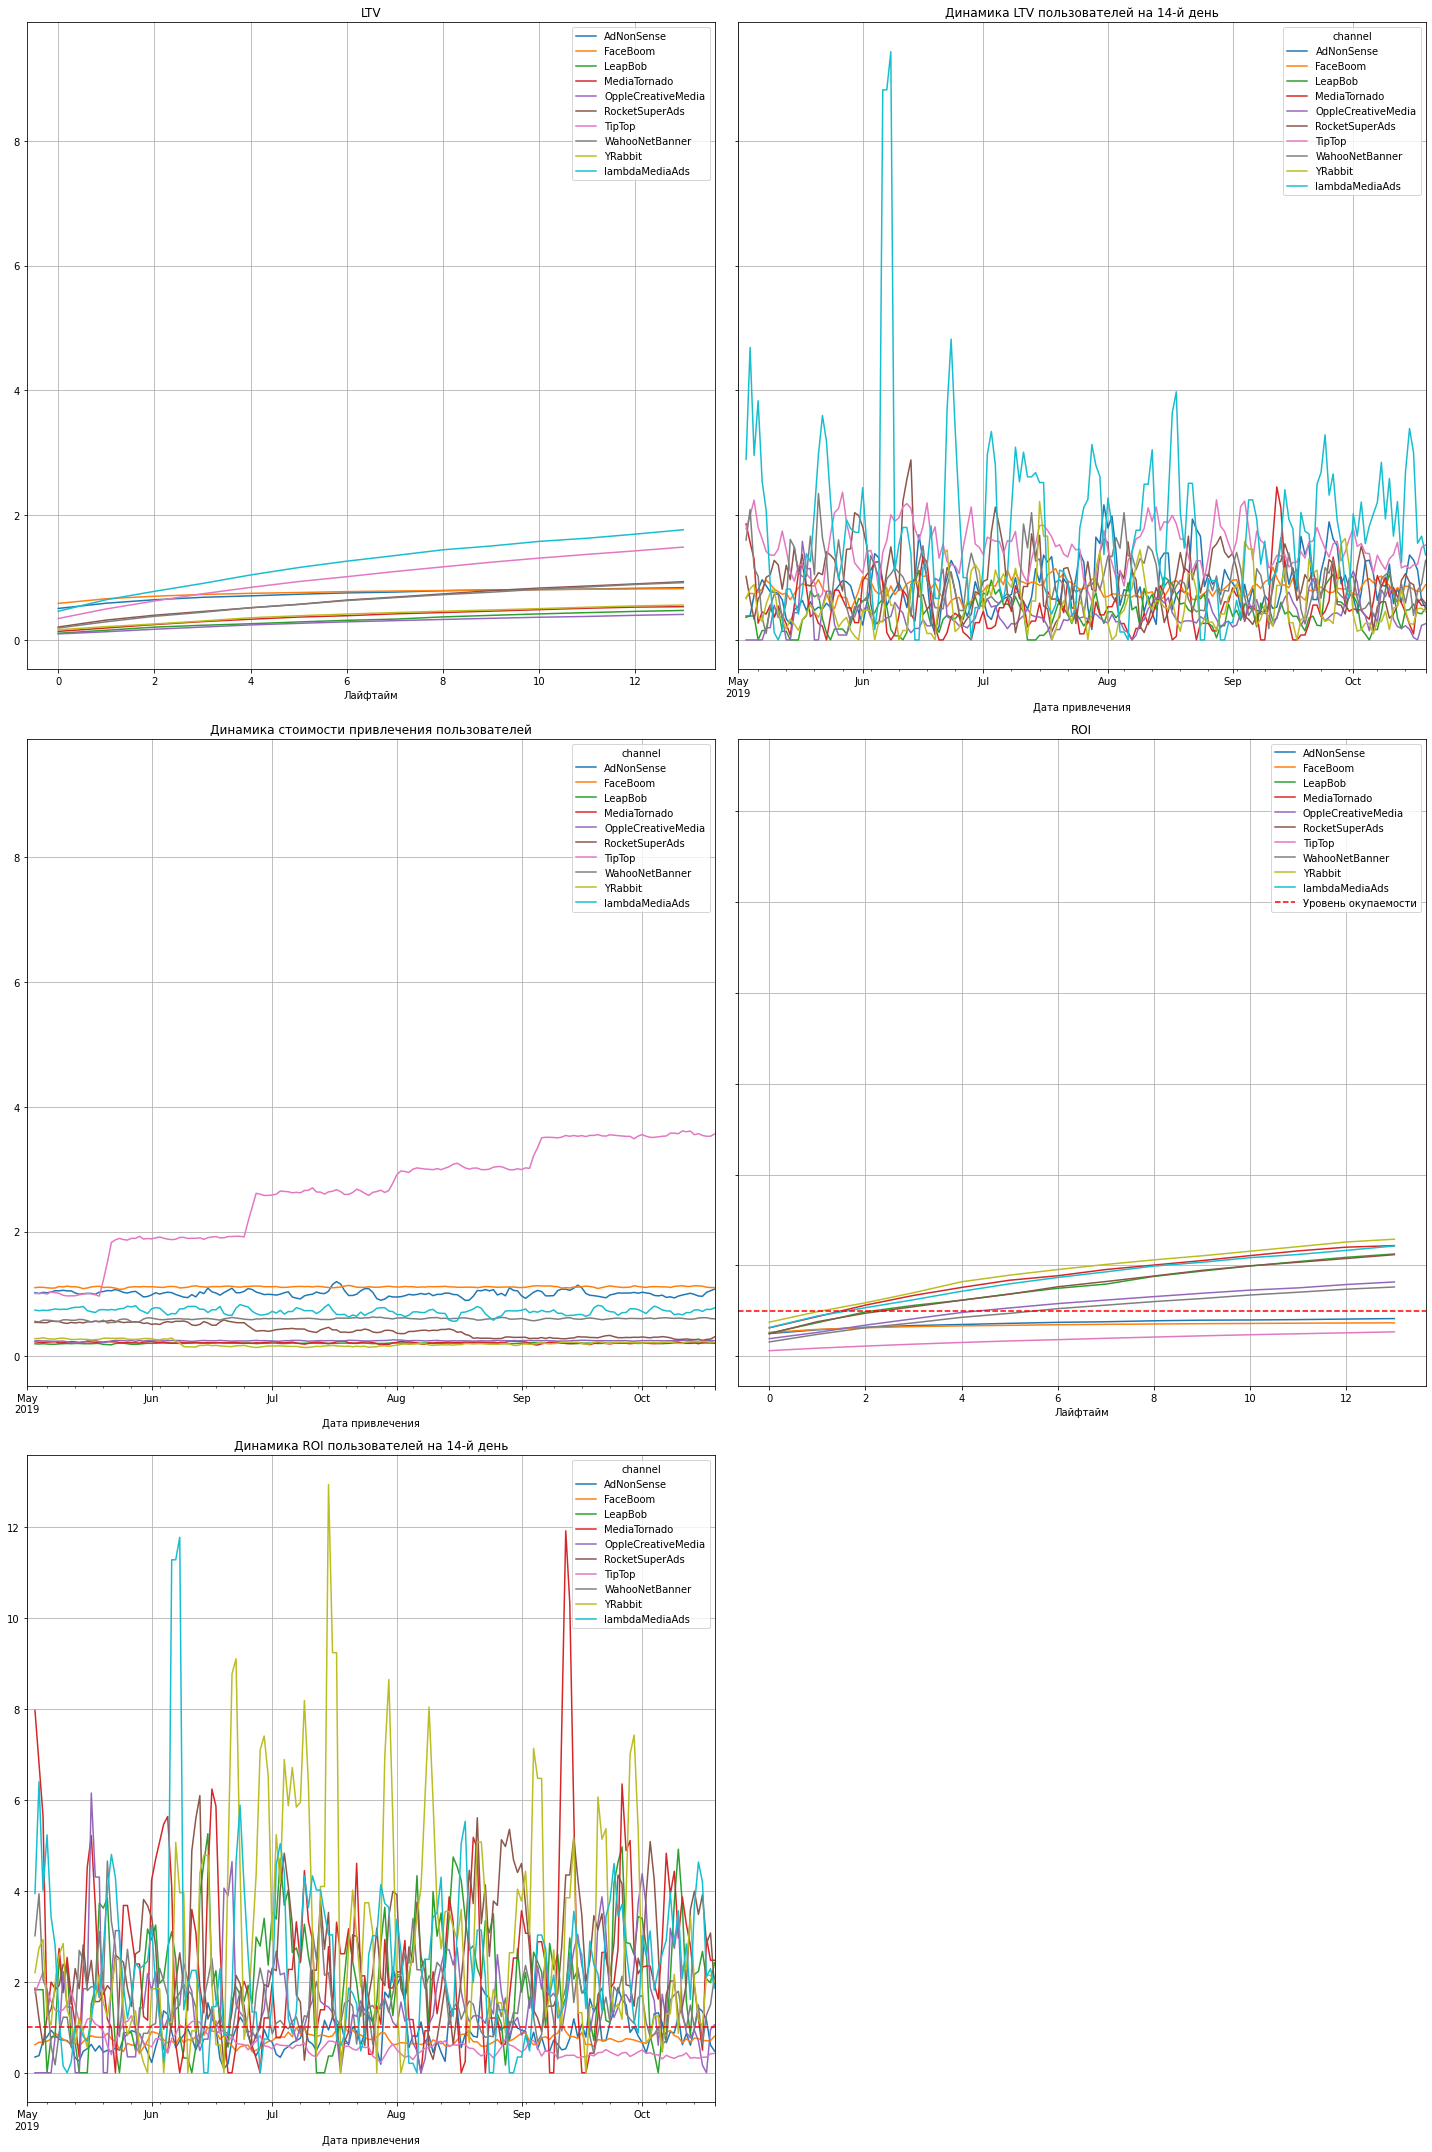

In [19]:
users = get_profiles(visits, orders, events, costs, event_names=[])  # профили с CAC
users = users.query('channel != "organic"')

# получите сырые данные, таблицы LTV и ROI, а также таблицы динамики LTV и ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    users,
    orders,
    datetime(2019, 11, 1).date(),
    14,
    dimensions=['channel']
)

display(roi)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=3)

Хуже всего окупается реклама на платформах TipTop, FaceBoom и AdNonSense, а самые высокие показатели у платформ YRabbit, lamdaMediaAds, Tornado. У платформы TipTop слишком высокая стоимость привлечения и она постоянно увеличивается.

In [20]:
visits['region'].unique()

array(['United States', 'UK', 'France', 'Germany'], dtype=object)

cohort_size       cac       0.0       1.0       2.0       3.0  \
channel                                                                         
FaceBoom              27759  1.104795  0.555427  0.623873  0.659868  0.685450   
MediaTornado           4314  0.211572  1.784742  2.048273  2.344607  2.574327   
RocketSuperAds         4411  0.402290  1.127782  1.410735  1.624469  1.781944   
TipTop                18717  2.725506  0.146039  0.203703  0.250643  0.293279   
YRabbit                4282  0.207961  1.848376  2.101674  2.325821  2.574639   

                     4.0       5.0       6.0       7.0       8.0       9.0  \
channel                                                                      
FaceBoom        0.702863  0.715392  0.728767  0.738110  0.745954  0.753960   
MediaTornado    2.761405  2.952768  3.056644  3.204269  3.319101  3.445942   
RocketSuperAds  1.933238  2.074404  2.251620  2.378168  2.508138  2.653271   
TipTop          0.331042  0.365185  0.394044  0.424548  0.451922  0.479568   
YRabbit         2.838123  2.989422  3.118306  3.241597  3.342463  3.443329   

                    10.0      11.0      12.0      13.0  
channel                                                 
FaceBoom        0.759364  0.765872  0.770919  0.774987  
MediaTornado    3.604501  3.730246  3.828655  3.885529  
RocketSuperAds  2.769129  2.870369  2.963736  3.053722  
TipTop          0.503476  0.526053  0.546813  0.569078  
YRabbit         3.555402  3.684309  3.814316  3.892767

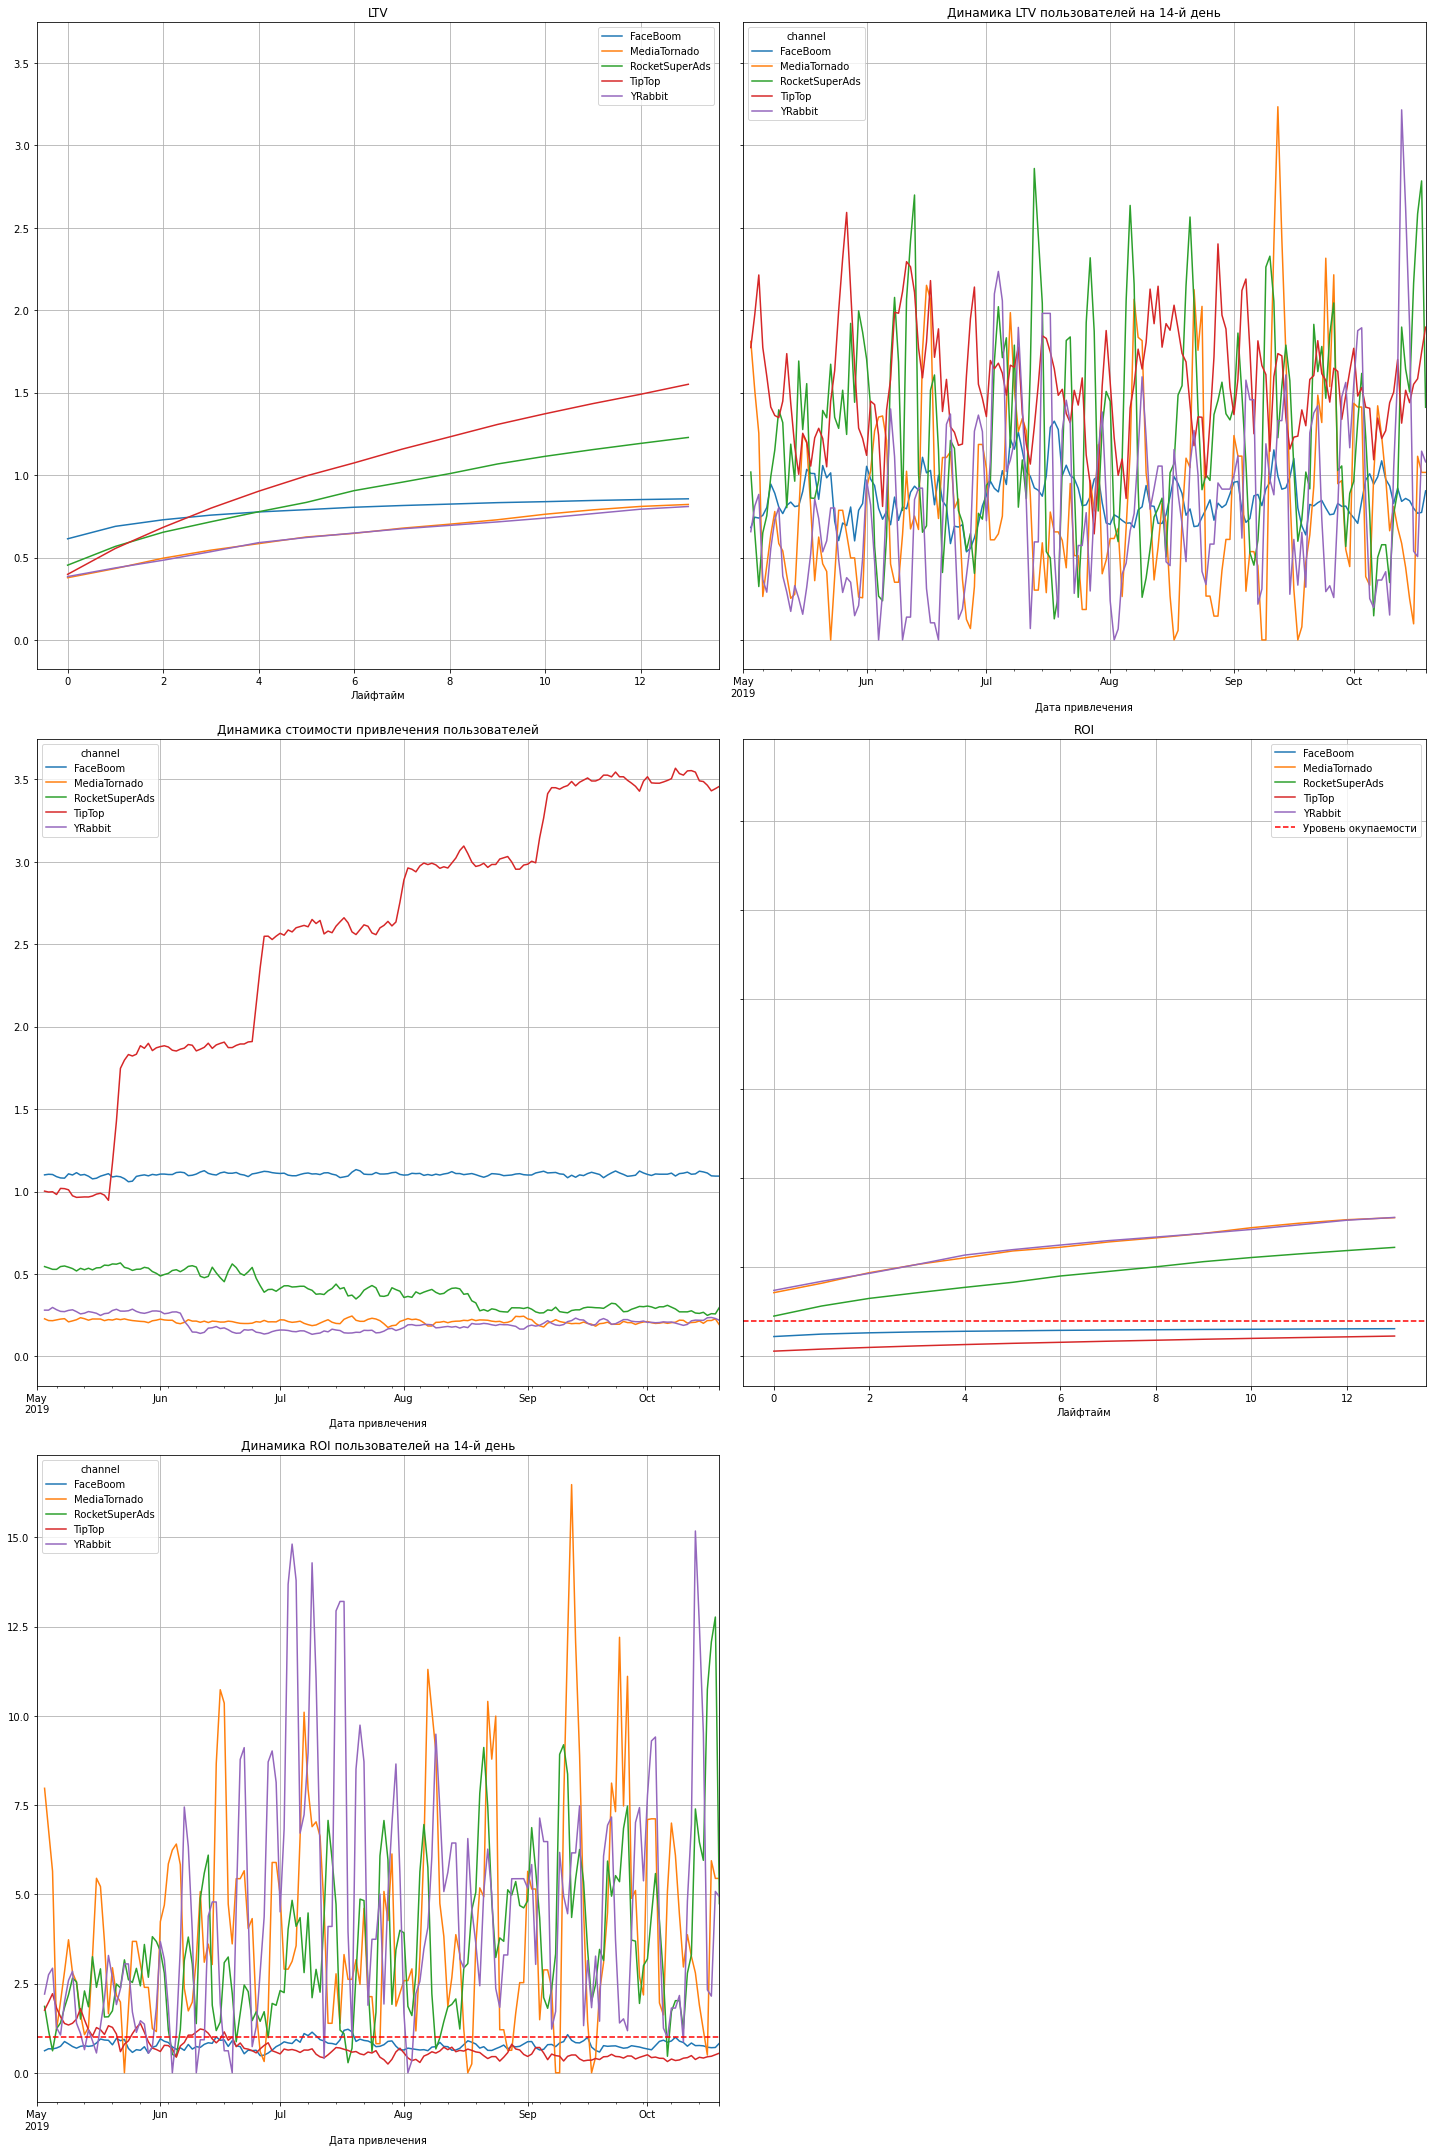

In [21]:
#отдельно смотрим окупаемость по каналам только в США

visits_usa = visits.query('region=="United States" and channel !="organic"')

users_usa = get_profiles(visits_usa, orders, events, costs, event_names=[])  # профили с CAC

# получите сырые данные, таблицы LTV и ROI, а также таблицы динамики LTV и ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    users_usa,
    orders,
    datetime(2019, 11, 1).date(),
    14,
    dimensions=['channel']
)

display(roi)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=3)

По США тоже выделяется неэффективный канал TipTop.

cohort_size       cac       0.0       1.0       2.0  \
channel                                                                   
AdNonSense                 3801  0.981768  0.717689  0.802476  0.863990   
LeapBob                    8194  0.207668  0.780728  1.021209  1.258740   
OppleCreativeMedia         8232  0.247085  0.622178  0.762035  0.922527   
WahooNetBanner             8167  0.595592  0.416767  0.589367  0.736709   
lambdaMediaAds             2139  0.699018  0.930043  1.197826  1.381380   

                         3.0       4.0       5.0       6.0       7.0  \
channel                                                                
AdNonSense          0.912131  0.941817  0.967500  0.996918  1.011627   
LeapBob             1.406545  1.525020  1.668718  1.798335  1.904503   
OppleCreativeMedia  1.072193  1.210113  1.318058  1.416195  1.498628   
WahooNetBanner      0.844431  0.965902  1.055362  1.162119  1.241111   
lambdaMediaAds      1.559009  1.759316  1.922853  2.066359  2.193178   

                         8.0       9.0      10.0      11.0      12.0      13.0  
channel                                                                         
AdNonSense          1.037042  1.051751  1.060042  1.070740  1.086786  1.098829  
LeapBob             2.086429  2.209593  2.326898  2.429541  2.523381  2.605490  
OppleCreativeMedia  1.577178  1.653235  1.724872  1.776883  1.857886  1.916765  
WahooNetBanner      1.319495  1.386181  1.467429  1.529598  1.598339  1.646762  
lambdaMediaAds      2.327348  2.414119  2.518914  2.592335  2.689145  2.789272

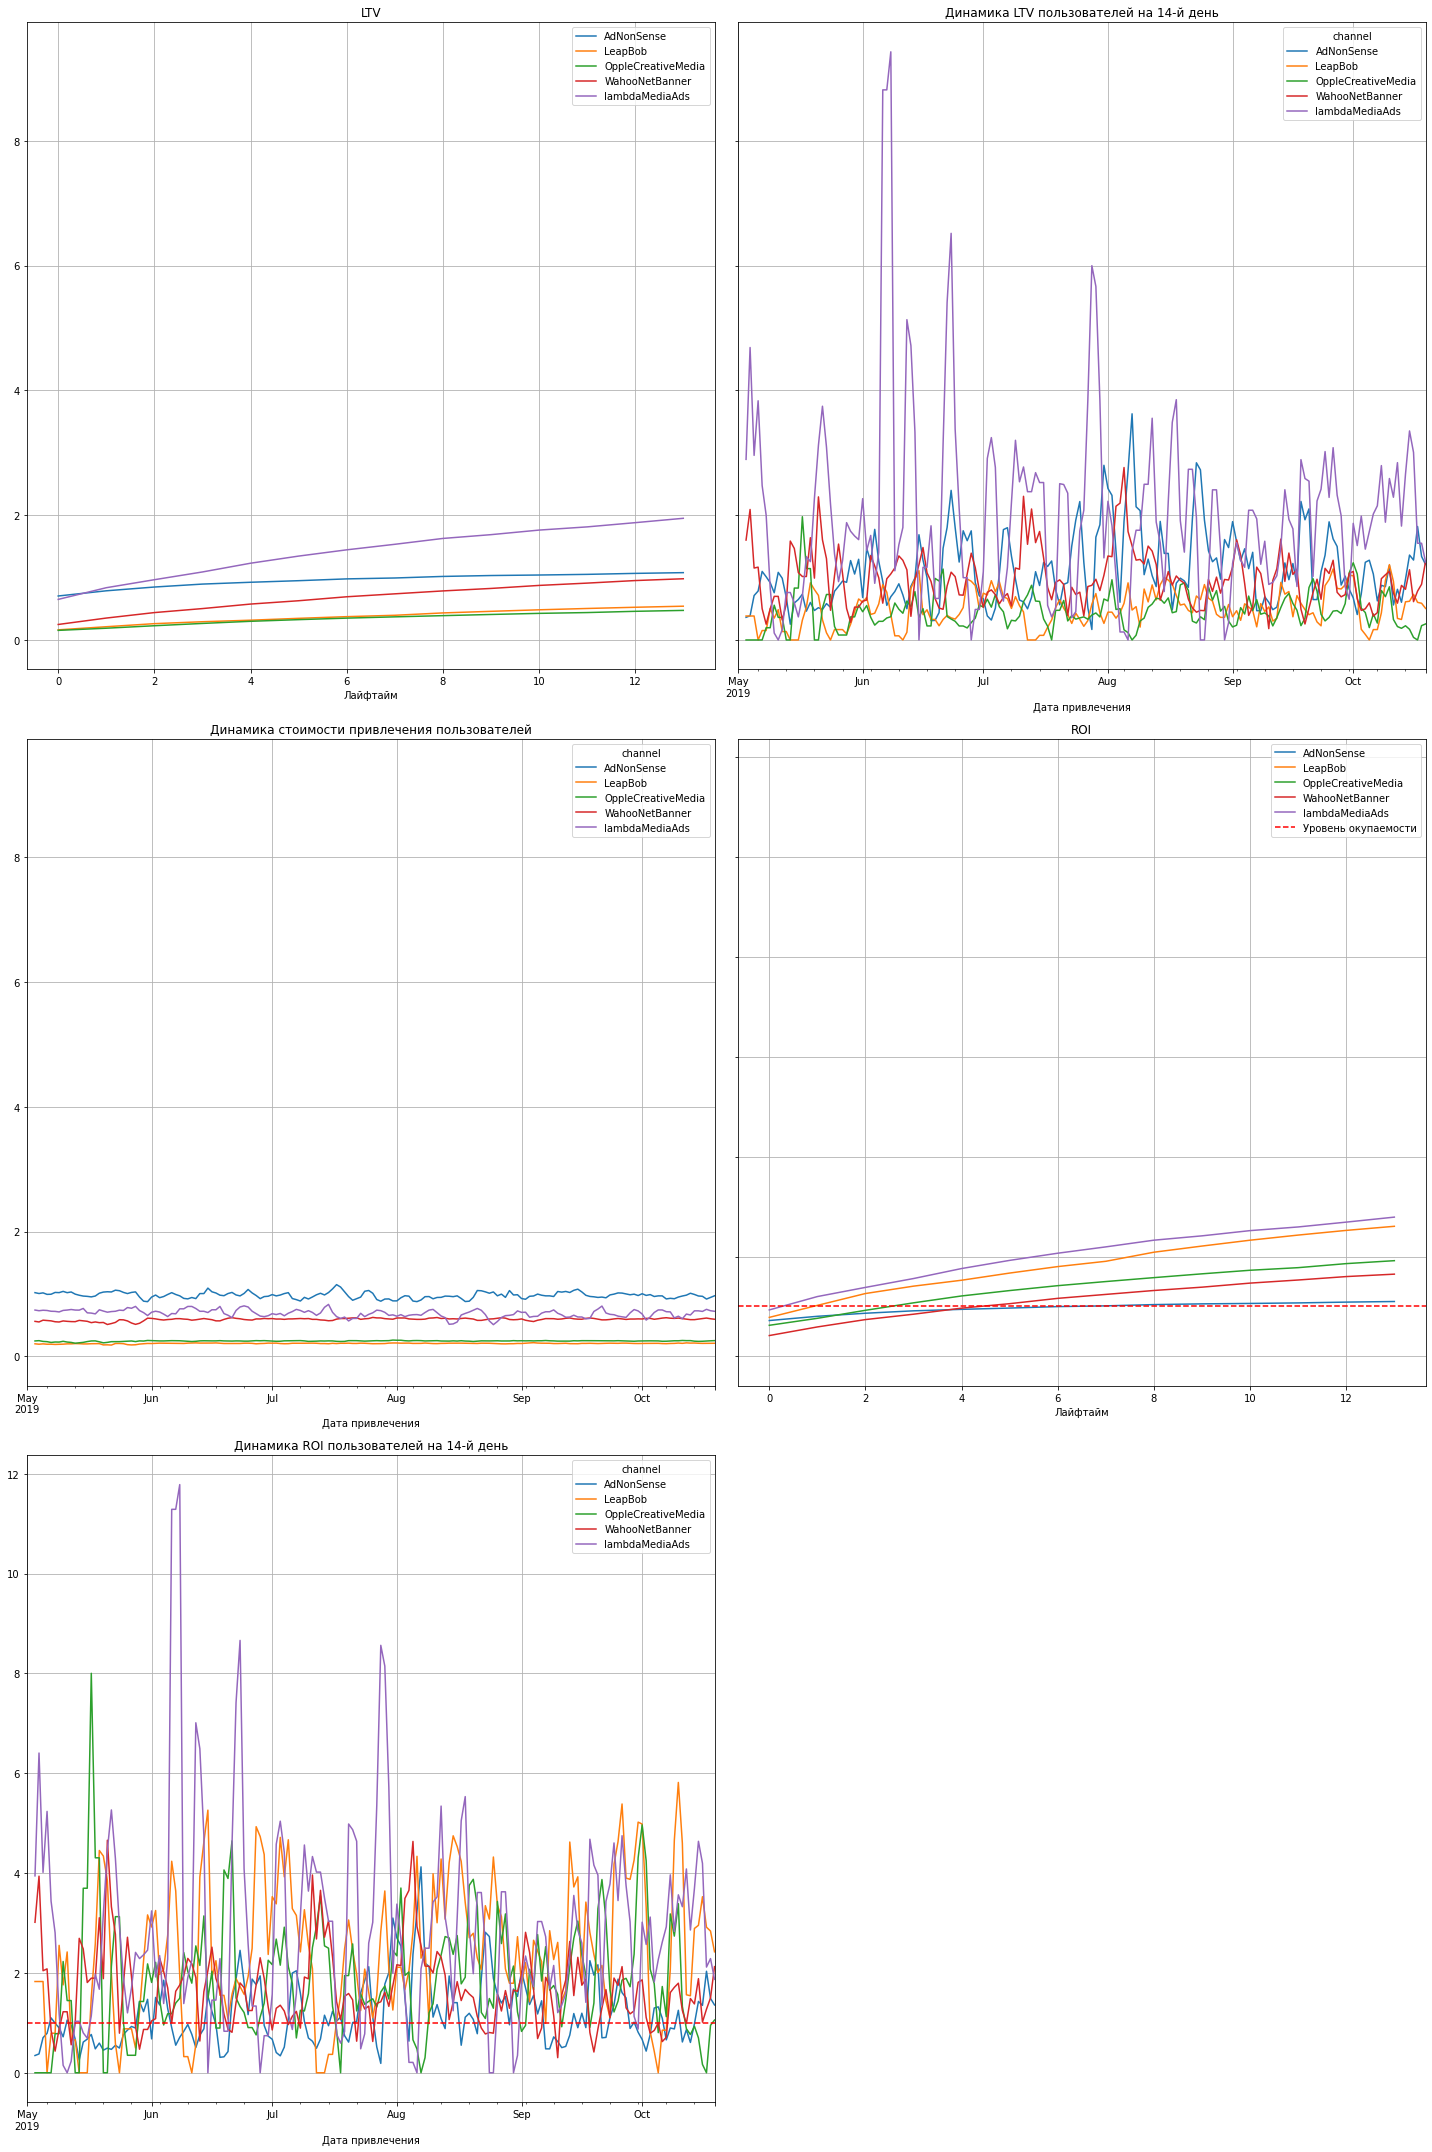

In [22]:
visits_eu = visits.query('region != "United States" and channel !="organic"')

users_eu = get_profiles(visits_eu, orders, events, costs, event_names=[])  # профили с CAC

# получите сырые данные, таблицы LTV и ROI, а также таблицы динамики LTV и ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    users_eu,
    orders,
    datetime(2019, 11, 1).date(),
    14,
    dimensions=['channel']
)

display(roi)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=3)

Получается, что основная проблема рекламы в США в больших затратах на канал TipTop.

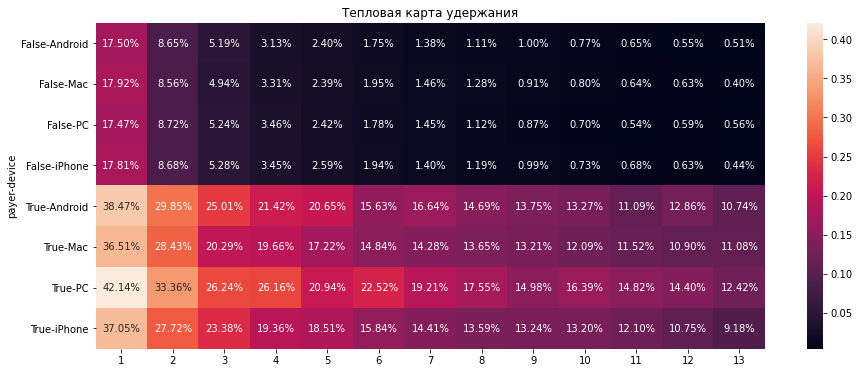

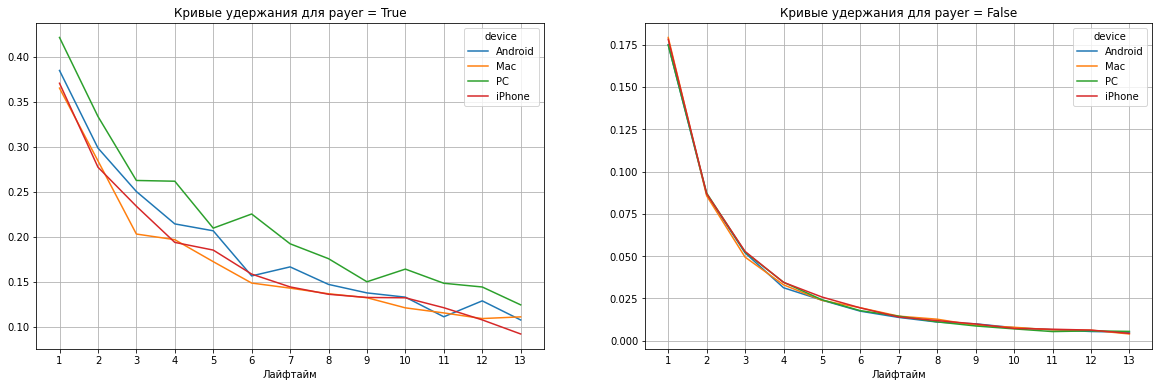

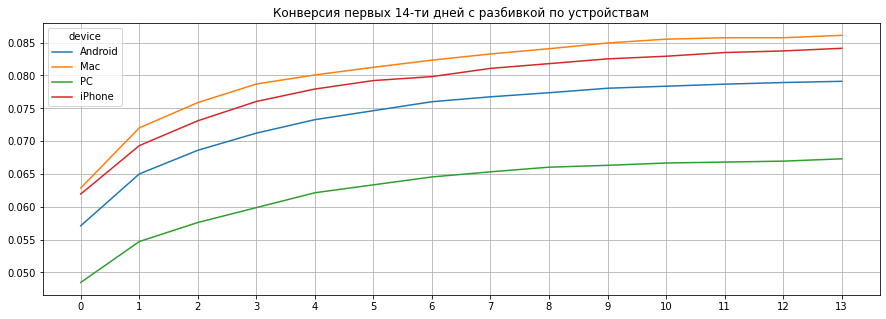

In [23]:
retention_raw, retention = get_retention(
    profiles, visits, datetime(2019, 11, 1).date(), 14, dimensions=['device']
)  # передаём dt в качестве параметра dimensions

# строим тепловую карту
plt.figure(figsize=(15, 6))
sns.heatmap(retention.drop(columns=['cohort_size', 0]), annot=True, fmt='.2%')
plt.title('Тепловая карта удержания')
plt.show()

# строим кривые удержания

plt.figure(figsize=(20, 6))  # задаём размер сетки

# исключаем размеры когорт и удержание первого дня
report = retention.drop(columns=['cohort_size', 0])

for i, payer in enumerate(profiles['payer'].unique()):
    report.query('payer == @payer').droplevel('payer').T.plot(
        grid=True,  # добавляем сетку
        # отметки на оси X — названия колонок
        xticks=list(report.columns.values),
        ax=plt.subplot(1, 2, i + 1), # задаём расположение графиков
    )
    plt.xlabel('Лайфтайм')
    plt.title('Кривые удержания для payer = {}'.format(payer))

plt.show()

conversion_raw, conversion, conversion_history = get_conversion(users, orders, datetime(2019, 10, 1).date(), 14, dimensions=['device'])# получите сырые данные, таблицу конверсии и таблицу динамики конверсии

report = conversion.drop(columns=['cohort_size'])
report.T.plot(
    grid=True, xticks=list(report.columns.values), figsize=(15,5)
)
plt.title('Конверсия первых 14-ти дней с разбивкой по устройствам')

plt.show()

Пользователи с устройствами Apple лучше конвертируются, но коэффициент удержания у них ниже.

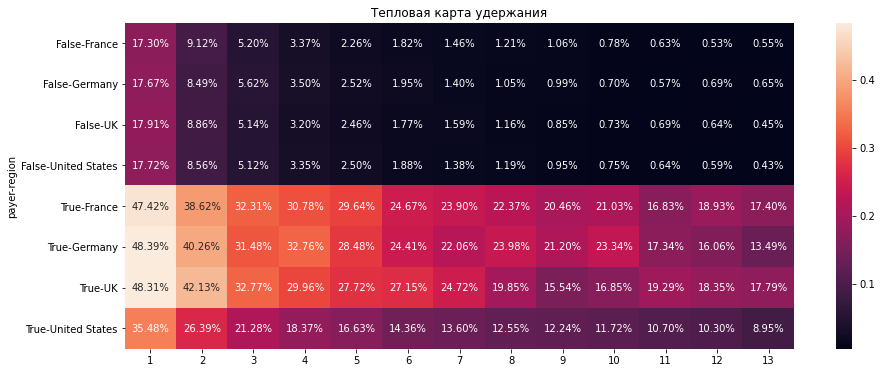

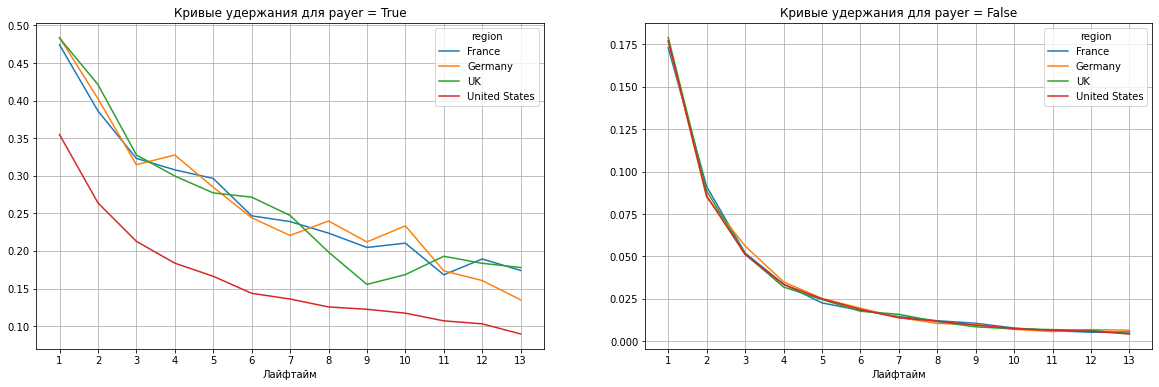

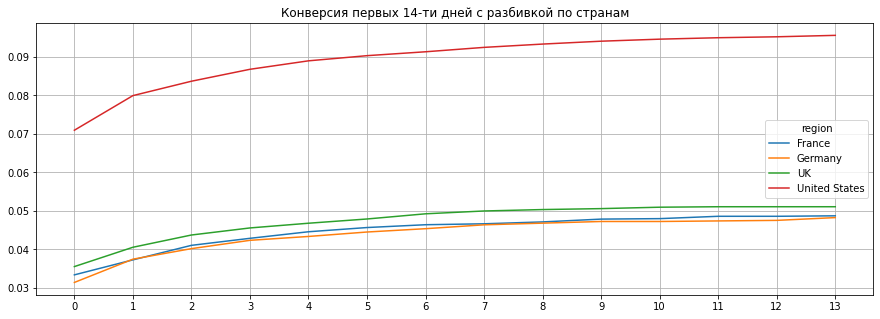

In [24]:
retention_raw, retention = get_retention(
    profiles, visits, datetime(2019, 11, 1).date(), 14, dimensions=['region']
)  # передаём dt в качестве параметра dimensions

# строим тепловую карту
plt.figure(figsize=(15, 6))
sns.heatmap(retention.drop(columns=['cohort_size', 0]), annot=True, fmt='.2%')
plt.title('Тепловая карта удержания')
plt.show()

# строим кривые удержания

plt.figure(figsize=(20, 6))  # задаём размер сетки

# исключаем размеры когорт и удержание первого дня
report = retention.drop(columns=['cohort_size', 0])

for i, payer in enumerate(profiles['payer'].unique()):
    report.query('payer == @payer').droplevel('payer').T.plot(
        grid=True,  # добавляем сетку
        # отметки на оси X — названия колонок
        xticks=list(report.columns.values),
        ax=plt.subplot(1, 2, i + 1), # задаём расположение графиков
    )
    plt.xlabel('Лайфтайм')
    plt.title('Кривые удержания для payer = {}'.format(payer))

plt.show()

conversion_raw, conversion, conversion_history = get_conversion(users, orders, datetime(2019, 10, 1).date(), 14, dimensions=['region'])# получите сырые данные, таблицу конверсии и таблицу динамики конверсии

report = conversion.drop(columns=['cohort_size'])
report.T.plot(
    grid=True, xticks=list(report.columns.values), figsize=(15,5)
)
plt.title('Конверсия первых 14-ти дней с разбивкой по странам')

plt.show()

Пользователи из Европы хуже конвертируются, а у пользователей из США очень низкий коэффициент удержания.

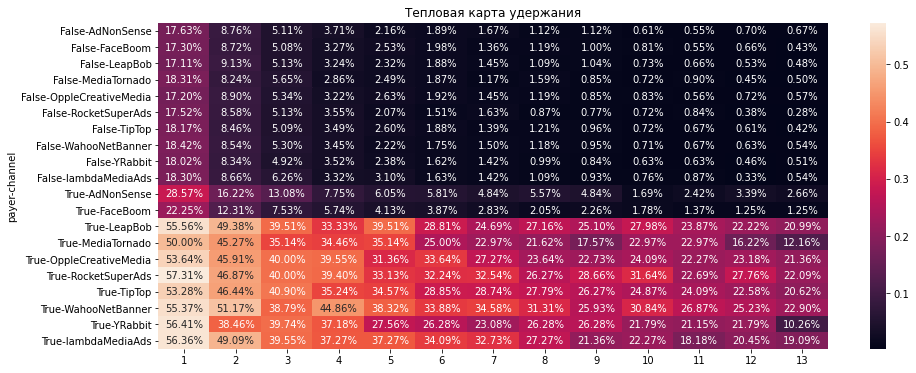

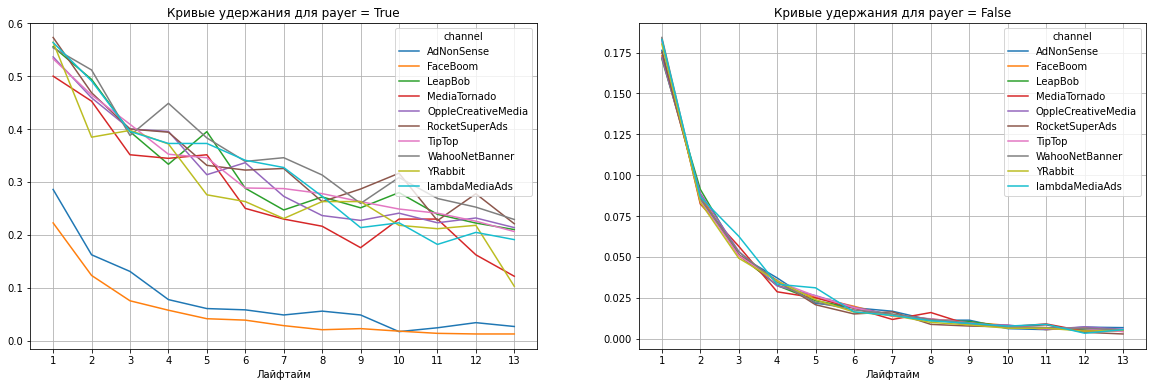

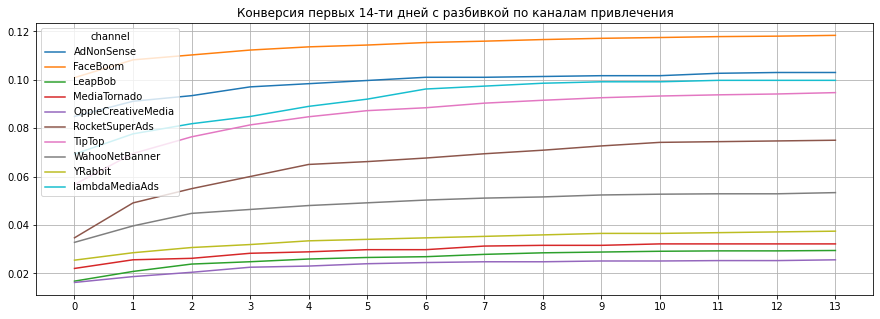

In [25]:
retention_raw, retention = get_retention(
    profiles, visits, datetime(2019, 11, 1).date(), 14, dimensions=['channel']
)  # передаём dt в качестве параметра dimensions

# строим тепловую карту
plt.figure(figsize=(15, 6))
sns.heatmap(retention.drop(columns=['cohort_size', 0]), annot=True, fmt='.2%')
plt.title('Тепловая карта удержания')
plt.show()

# строим кривые удержания

plt.figure(figsize=(20, 6))  # задаём размер сетки

# исключаем размеры когорт и удержание первого дня
report = retention.drop(columns=['cohort_size', 0])

for i, payer in enumerate(profiles['payer'].unique()):
    report.query('payer == @payer').droplevel('payer').T.plot(
        grid=True,  # добавляем сетку
        # отметки на оси X — названия колонок
        xticks=list(report.columns.values),
        ax=plt.subplot(1, 2, i + 1), # задаём расположение графиков
    )
    plt.xlabel('Лайфтайм')
    plt.title('Кривые удержания для payer = {}'.format(payer))

plt.show()

conversion_raw, conversion, conversion_history = get_conversion(users, orders, datetime(2019, 10, 1).date(), 14, dimensions=['channel'])# получите сырые данные, таблицу конверсии и таблицу динамики конверсии

report = conversion.drop(columns=['cohort_size'])
report.T.plot(
    grid=True, xticks=list(report.columns.values), figsize=(15,5)
)
plt.title('Конверсия первых 14-ти дней с разбивкой по каналам привлечения')

plt.show()

Очень низкий коэффициент удержания у пользователей, пришедших из каналов FaceBoom и AdNonSense.

# Шаг 6. Напишите выводы
- Выделите причины неэффективности привлечения пользователей;
- Сформируйте рекомендации для отдела маркетинга для повышения эффективности.

Возможные причины неэффективности: 

- приложение плохо адаптировано для устройств Apple
- очень высокая стоимость привлечения клиентов из США
- у пользователей из США очень низкий коэффициент удержания
- используется много каналов привлечения и не все из них дают положительный результат: много денег тратится на рекламный канал TipTop, при этом эти затраты не окупаются

Рекомендации:

- CAC по США выше допустимого значения, и это приводит к финансовым проблемам, поэтому нужно изменить стратегию привлечения, отказаться от неэффективных каналов трафика, в первую очередь TipTop
- повысить удержание клиентов можно, например, с помощью персонализации, введения пограмм лояльности и премиум-статуса, пуш-уведомлений; можно провести реактиваицонную кампанию
- лучше сосредоточиться на нескольких наиболее прибыльных каналах - YRabbit, lamdaMediaAds, Tornado (особенно lamdaMediaAds, т.к. пользователи из этого канала хорошо конвертируются)
- можно попробовать увеличить конверсию покупателей из Европы - стимулировать их к совершению покупки, предлагать акции, скидки, бонусы